# Assignment 4 - Generative Adversarial Networks (GANs)
## Part 1: Theory Questions

**Course:** DS552 - Generative AI  
**Instructor:** Narahara Chari Dingari, Ph.D.

---


### Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

**Minimax Loss Function:**

The GAN objective is a minimax game:
$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

- The **discriminator** maximizes $V(D,G)$: it tries to correctly classify real samples (maximize $\log D(x)$) and reject fakes (maximize $\log(1-D(G(z)))$).
- The **generator** minimizes $V(D,G)$: it tries to make $D(G(z))$ large so that $\log(1-D(G(z)))$ is small, i.e., fool the discriminator.

**How It Ensures Competitive Training:**

1. **Adversarial objectives**: The generator and discriminator have opposing goals. The discriminator improves at distinguishing real vs fake, which forces the generator to produce more realistic samples to reduce its loss.
2. **Nash equilibrium**: Training alternates between updating D and G. At equilibrium, the generator matches the data distribution and the discriminator is at chance (0.5) everywhere.
3. **Gradient signal**: The discriminator’s output provides a learning signal for the generator; as D gets better, the generator must improve to keep fooling it, leading to a competitive co-evolution of both networks.


### Q2: What is mode collapse? Why can mode collapse occur during GAN training? How can it be mitigated?

**What is Mode Collapse?**

Mode collapse occurs when the generator produces limited diversity, mapping many different noise inputs to the same or very similar outputs. The generator may only capture a few modes of the data distribution (e.g., only one digit in MNIST) instead of the full diversity.

**Why It Occurs:**

1. **Discriminator overpowering**: If the discriminator becomes too strong, it rejects most generator outputs. The generator may then find a few “safe” outputs that consistently fool D and keep producing those.
2. **Optimization landscape**: The generator can get stuck in local minima where producing a narrow set of samples minimizes its loss.
3. **Poor gradient signal**: When D is very confident, gradients for the generator can vanish, so the generator stops exploring.
4. **Insufficient capacity or exploration**: The generator may not have enough capacity or may not explore the latent space well.

**Mitigation:**

- **Wasserstein GAN (WGAN)**: More stable gradients and better correlation with sample quality.
- **Unrolled GANs / gradient penalty**: Prevent the discriminator from becoming too strong too quickly.
- **Mini-batch discrimination**: Let the discriminator see multiple samples at once to detect lack of diversity.
- **Spectral normalization**: Limit the discriminator’s Lipschitz constant to stabilize training.
- **Label smoothing**: Use soft labels (e.g., 0.9 instead of 1.0 for real) to avoid overconfident D.
- **Two time-scale updates (TTUR)**: Use different learning rates for G and D to balance training.


### Q3: Explain the role of the discriminator in adversarial training.

**Role of the Discriminator:**

1. **Binary classifier**: The discriminator acts as a binary classifier that takes a sample (real or generated) and outputs a score or probability that the sample is real. It is trained to assign high scores to real data and low scores to generated data.

2. **Provider of learning signal**: The discriminator’s output is the only direct feedback the generator receives. The generator is trained to maximize the probability that its outputs are classified as real. So the discriminator’s gradients with respect to the generated samples drive the generator’s updates.

3. **Adversarial pressure**: By improving at distinguishing real from fake, the discriminator constantly raises the bar for the generator. This adversarial pressure pushes the generator to produce more realistic and diverse samples.

4. **Training dynamics**: Training alternates between updating the discriminator (on real vs fake batches) and the generator (to fool the discriminator). The discriminator must be strong enough to provide useful gradients but not so strong that the generator’s gradients vanish; balancing this is key to stable GAN training.


### Q4: How do metrics like IS and FID evaluate GAN performance?

**Inception Score (IS):**

- **Idea**: Use a pre-trained Inception network to measure the quality and diversity of generated images.
- **Computation**: Pass generated images through Inception; compute $\exp(\mathbb{E}[KL(p(y|x) \| p(y))])$, where $p(y|x)$ is the conditional class distribution for each image and $p(y)$ is the marginal.
- **Interpretation**: High conditional entropy $H(y|x)$ means each image is confidently classified (sharp, recognizable). High marginal entropy $H(y)$ means many classes are represented (diverse). So higher IS suggests both quality and diversity.
- **Limitation**: IS uses only generated images and does not compare to the real data distribution.

**Fréchet Inception Distance (FID):**

- **Idea**: Compare the distribution of real and generated images in the feature space of a pre-trained Inception network.
- **Computation**: Extract features for real and generated images; fit Gaussians $N(\mu_r, \Sigma_r)$ and $N(\mu_g, \Sigma_g)$; compute the Fréchet distance: $\|\mu_r - \mu_g\|^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$.
- **Interpretation**: Lower FID means the generated distribution is closer to the real distribution in feature space, i.e., better quality and diversity.
- **Advantage**: FID compares directly to the real data and is generally more reliable than IS. It is sensitive to mode collapse (low diversity increases FID).


# Assignment 4 - Generative Adversarial Networks (GANs)
## Part 2: Coding Assignment

**Course:** DS552 - Generative AI  
**Instructor:** Narahara Chari Dingari, Ph.D.

---

## Assignment Requirements (from PDF)

1. **Modify the generator** to include additional convolutional layers.
2. **Implement image saving** after every 10 epochs.
3. **Replace MNIST with CIFAR-10** and update the network for the new dimensions (32×32×3).

## Implementation Overview

- **Task 1**: GAN on MNIST with a convolutional generator, binary cross-entropy loss, and image saving every 10 epochs (aligned with the assignment starter code).
- **Task 2**: Same architecture adapted to CIFAR-10 (32×32×3) with updated dimensions.
- **Extensions**: WGAN-GP and Conditional GAN are included as optional experiments.


## Task 1: GAN on MNIST (Assignment Base)

Implement a GAN on MNIST with:
- **Generator**: Convolutional layers (Dense → Reshape → ConvTranspose layers) to map noise to 28×28 images, as in the assignment starter code.
- **Discriminator**: Convolutional classifier for real vs fake.
- **Loss**: Binary cross-entropy for both.
- **Training**: Alternate updates for discriminator and generator; **save generated images every 10 epochs**.


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


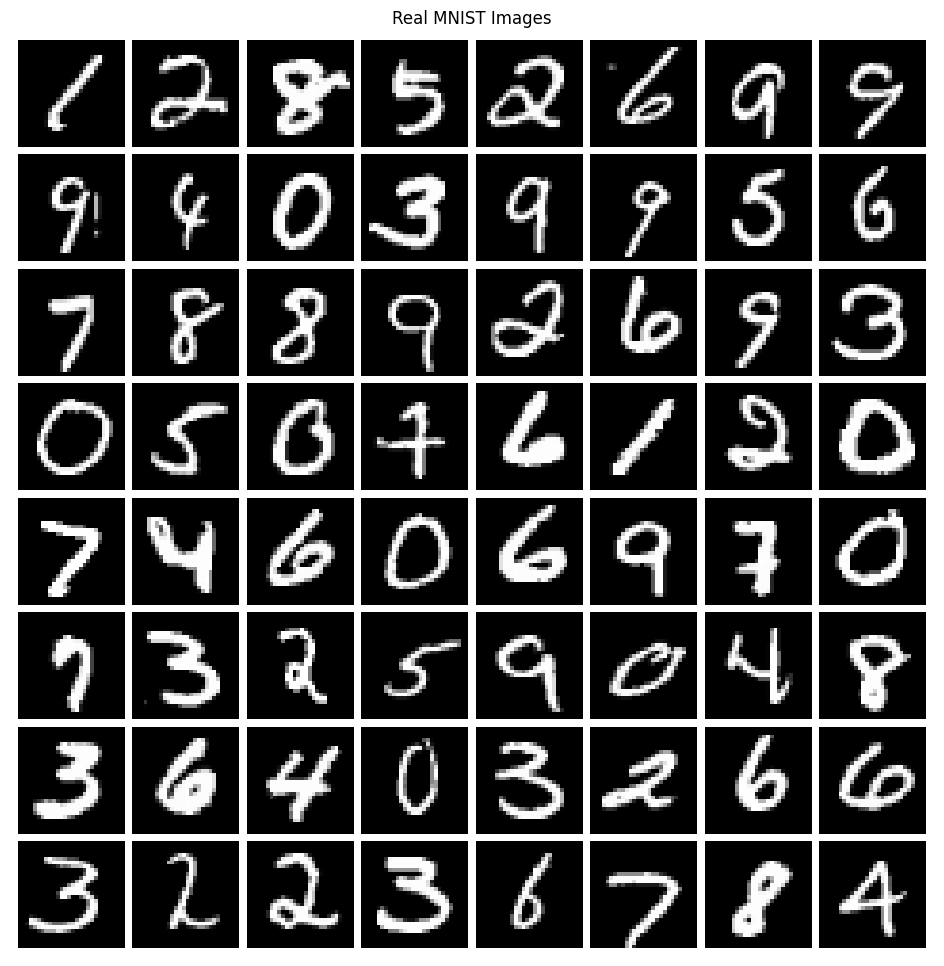

In [4]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# Visualize some real images
def show_images(images, title="Images", nrow=8):
    """Helper function to display images"""
    images = images.cpu()
    grid = make_grid(images, nrow=nrow, normalize=True, pad_value=1)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample real images
real_images, _ = next(iter(train_loader))
show_images(real_images[:64], "Real MNIST Images")

In [5]:
# Define Generator Network (with convolutional layers, as in assignment PDF)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=28, n_channels=1):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        # Dense -> Reshape to 7x7x256, then ConvTranspose layers (matches PDF architecture)
        self.fc = nn.Linear(latent_dim, 7 * 7 * 256)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, n_channels, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 7, 7)
        img = self.model(x)
        return img

# Define Discriminator Network (convolutional, as in assignment PDF)
class Discriminator(nn.Module):
    def __init__(self, img_size=28, n_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)

# Initialize networks
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Print model architectures
print("Generator:")
print(generator)
print("\nDiscriminator:")
print(discriminator)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGenerator parameters: {count_parameters(generator):,}")
print(f"Discriminator parameters: {count_parameters(discriminator):,}")

Generator:
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

Discriminator:
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [6]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training parameters
n_epochs = 50
print_every = 100
save_every = 10

# Create directory for saving generated images
os.makedirs('generated_images/basic_gan', exist_ok=True)

# Training history
G_losses = []
D_losses = []

Starting training...
[Epoch 0/50] [Batch 0/938] [D loss: 0.6619] [G loss: 0.7501]
[Epoch 0/50] [Batch 100/938] [D loss: 0.7309] [G loss: 0.9998]
[Epoch 0/50] [Batch 200/938] [D loss: 0.6555] [G loss: 0.7191]
[Epoch 0/50] [Batch 300/938] [D loss: 0.6718] [G loss: 0.9935]
[Epoch 0/50] [Batch 400/938] [D loss: 0.6335] [G loss: 0.6913]
[Epoch 0/50] [Batch 500/938] [D loss: 0.6511] [G loss: 0.6678]
[Epoch 0/50] [Batch 600/938] [D loss: 0.6045] [G loss: 0.9614]
[Epoch 0/50] [Batch 700/938] [D loss: 0.6282] [G loss: 0.6568]
[Epoch 0/50] [Batch 800/938] [D loss: 0.6014] [G loss: 0.7428]
[Epoch 0/50] [Batch 900/938] [D loss: 0.5876] [G loss: 0.9380]


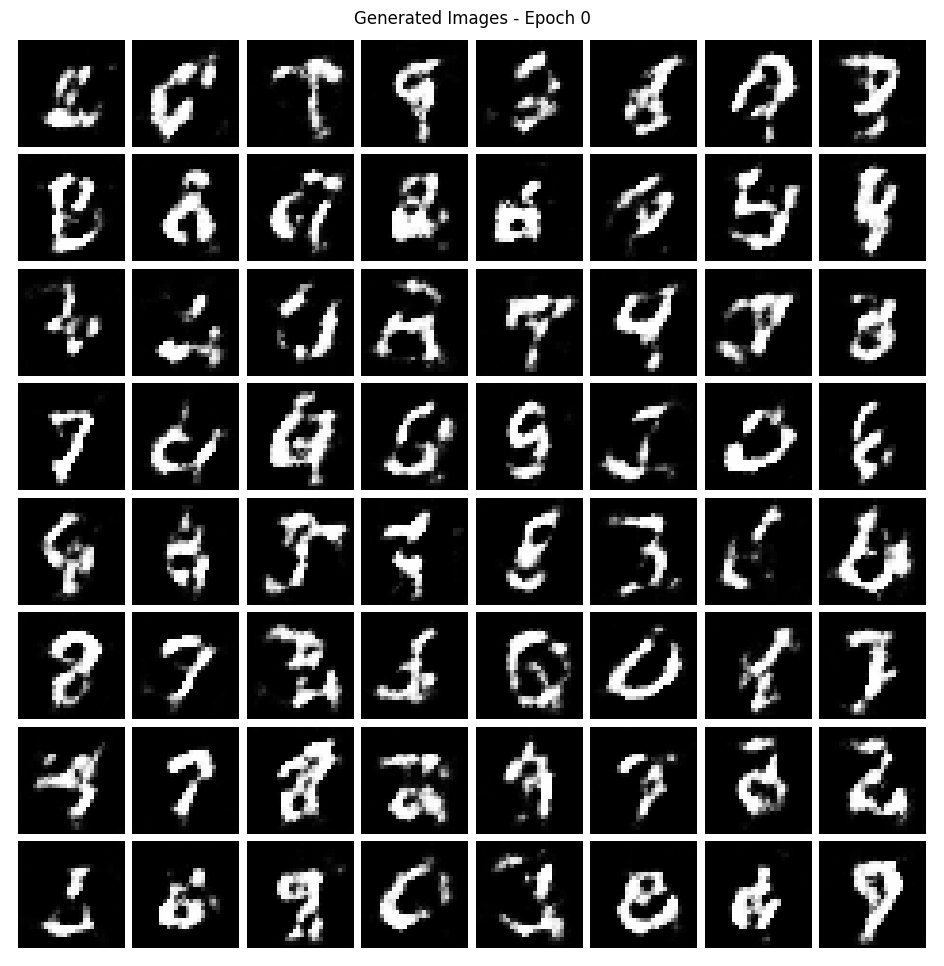

[Epoch 1/50] [Batch 0/938] [D loss: 0.6110] [G loss: 1.0642]
[Epoch 1/50] [Batch 100/938] [D loss: 0.6079] [G loss: 0.7753]
[Epoch 1/50] [Batch 200/938] [D loss: 0.6009] [G loss: 0.9022]
[Epoch 1/50] [Batch 300/938] [D loss: 0.6410] [G loss: 0.6795]
[Epoch 1/50] [Batch 400/938] [D loss: 0.5911] [G loss: 1.1968]
[Epoch 1/50] [Batch 500/938] [D loss: 0.6137] [G loss: 0.9086]
[Epoch 1/50] [Batch 600/938] [D loss: 0.6177] [G loss: 1.1099]
[Epoch 1/50] [Batch 700/938] [D loss: 0.5910] [G loss: 0.7467]
[Epoch 1/50] [Batch 800/938] [D loss: 0.6567] [G loss: 1.0365]
[Epoch 1/50] [Batch 900/938] [D loss: 0.6619] [G loss: 0.8234]
[Epoch 2/50] [Batch 0/938] [D loss: 0.6559] [G loss: 0.7801]
[Epoch 2/50] [Batch 100/938] [D loss: 0.6092] [G loss: 0.8733]
[Epoch 2/50] [Batch 200/938] [D loss: 0.6248] [G loss: 0.7802]
[Epoch 2/50] [Batch 300/938] [D loss: 0.6837] [G loss: 0.8231]
[Epoch 2/50] [Batch 400/938] [D loss: 0.6138] [G loss: 0.7728]
[Epoch 2/50] [Batch 500/938] [D loss: 0.6527] [G loss: 0.87

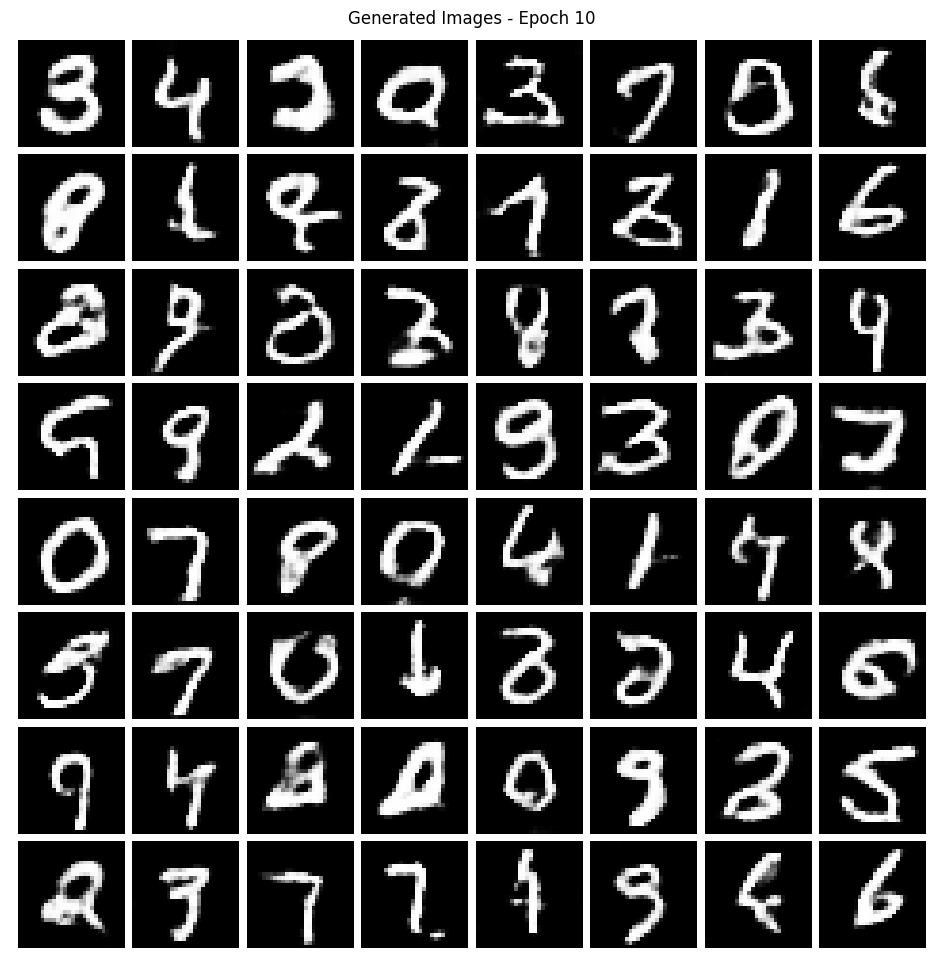

[Epoch 11/50] [Batch 0/938] [D loss: 0.6620] [G loss: 1.0636]
[Epoch 11/50] [Batch 100/938] [D loss: 0.6171] [G loss: 0.9170]
[Epoch 11/50] [Batch 200/938] [D loss: 0.6196] [G loss: 0.9361]
[Epoch 11/50] [Batch 300/938] [D loss: 0.6443] [G loss: 0.8623]
[Epoch 11/50] [Batch 400/938] [D loss: 0.6662] [G loss: 0.8495]
[Epoch 11/50] [Batch 500/938] [D loss: 0.6369] [G loss: 0.8146]
[Epoch 11/50] [Batch 600/938] [D loss: 0.6579] [G loss: 0.8732]
[Epoch 11/50] [Batch 700/938] [D loss: 0.5678] [G loss: 1.0029]
[Epoch 11/50] [Batch 800/938] [D loss: 0.6573] [G loss: 0.8217]
[Epoch 11/50] [Batch 900/938] [D loss: 0.6137] [G loss: 1.1451]
[Epoch 12/50] [Batch 0/938] [D loss: 0.6007] [G loss: 0.8465]
[Epoch 12/50] [Batch 100/938] [D loss: 0.5641] [G loss: 0.9218]
[Epoch 12/50] [Batch 200/938] [D loss: 0.6427] [G loss: 0.9569]
[Epoch 12/50] [Batch 300/938] [D loss: 0.6046] [G loss: 0.7991]
[Epoch 12/50] [Batch 400/938] [D loss: 0.6654] [G loss: 0.8417]
[Epoch 12/50] [Batch 500/938] [D loss: 0.616

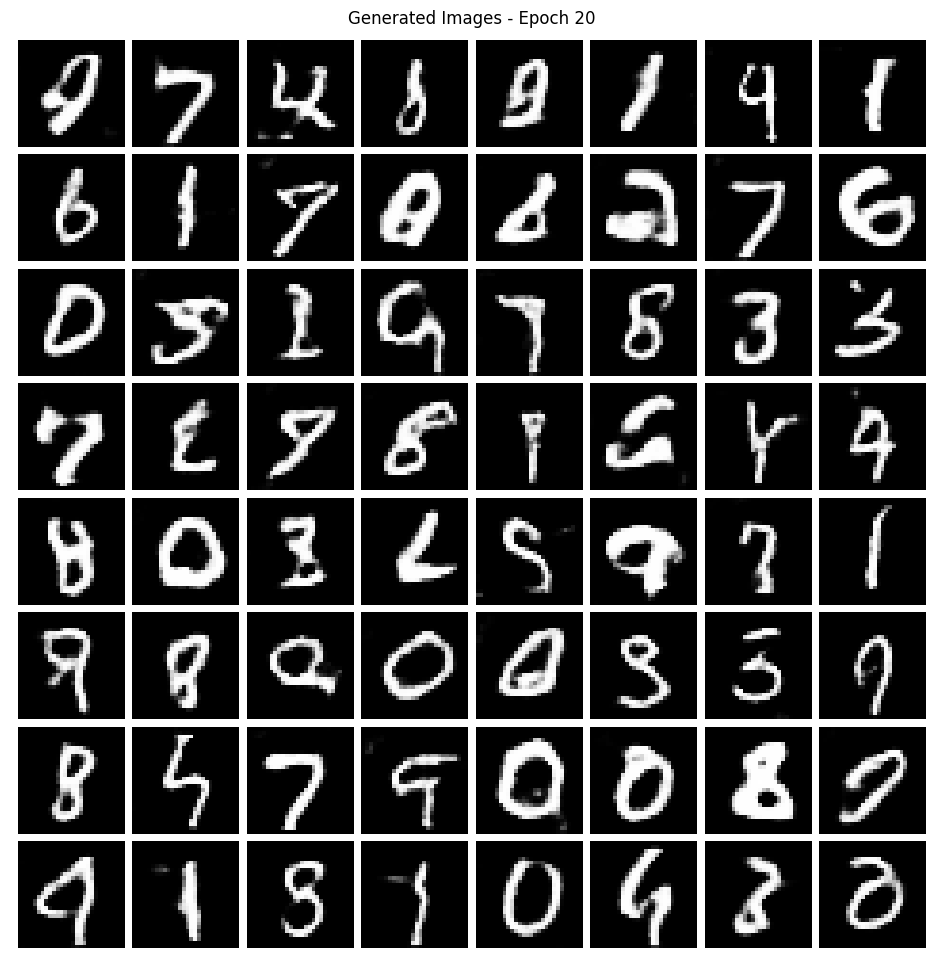

[Epoch 21/50] [Batch 0/938] [D loss: 0.6621] [G loss: 1.0244]
[Epoch 21/50] [Batch 100/938] [D loss: 0.6381] [G loss: 0.9633]
[Epoch 21/50] [Batch 200/938] [D loss: 0.5898] [G loss: 0.7831]
[Epoch 21/50] [Batch 300/938] [D loss: 0.5570] [G loss: 0.8889]
[Epoch 21/50] [Batch 400/938] [D loss: 0.6105] [G loss: 0.9346]
[Epoch 21/50] [Batch 500/938] [D loss: 0.6085] [G loss: 0.9800]
[Epoch 21/50] [Batch 600/938] [D loss: 0.6535] [G loss: 0.9829]
[Epoch 21/50] [Batch 700/938] [D loss: 0.6125] [G loss: 1.0037]
[Epoch 21/50] [Batch 800/938] [D loss: 0.6045] [G loss: 1.0418]
[Epoch 21/50] [Batch 900/938] [D loss: 0.6977] [G loss: 0.9527]
[Epoch 22/50] [Batch 0/938] [D loss: 0.6284] [G loss: 0.8880]
[Epoch 22/50] [Batch 100/938] [D loss: 0.6010] [G loss: 0.9300]
[Epoch 22/50] [Batch 200/938] [D loss: 0.5802] [G loss: 0.8442]
[Epoch 22/50] [Batch 300/938] [D loss: 0.5678] [G loss: 0.7511]
[Epoch 22/50] [Batch 400/938] [D loss: 0.6571] [G loss: 0.7941]
[Epoch 22/50] [Batch 500/938] [D loss: 0.602

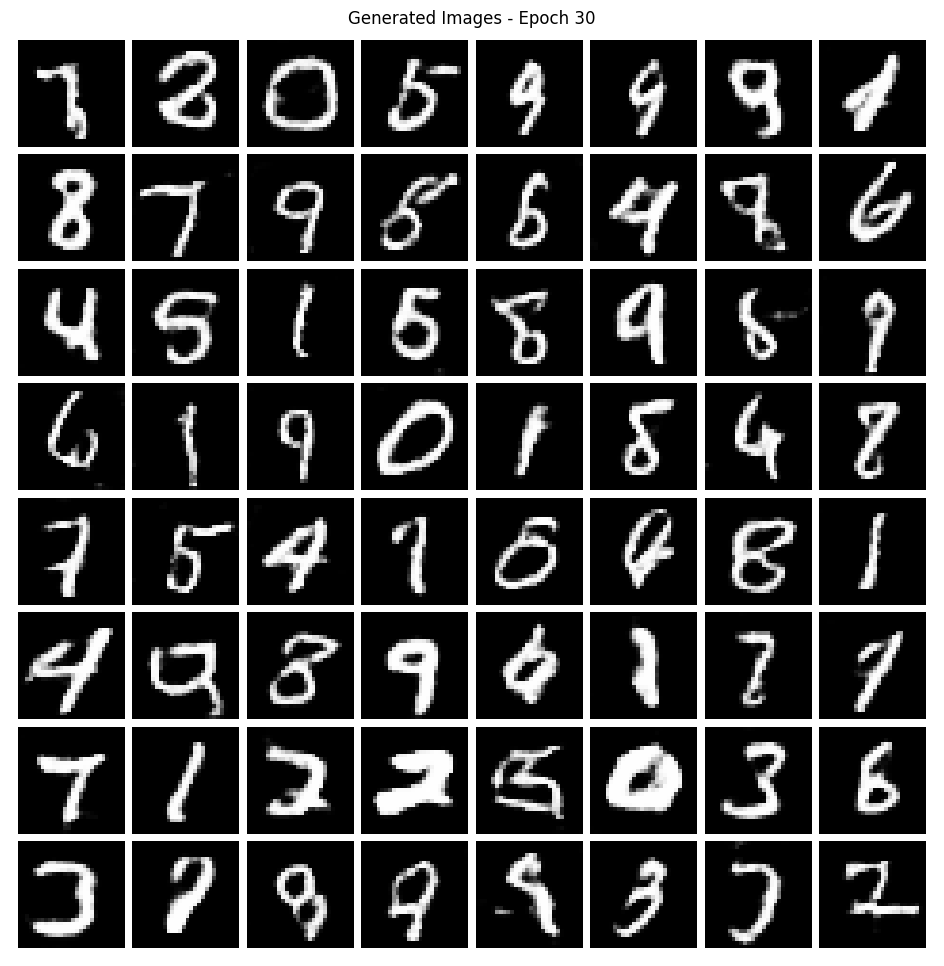

[Epoch 31/50] [Batch 0/938] [D loss: 0.6117] [G loss: 0.9759]
[Epoch 31/50] [Batch 100/938] [D loss: 0.6273] [G loss: 0.9190]
[Epoch 31/50] [Batch 200/938] [D loss: 0.6009] [G loss: 1.0268]
[Epoch 31/50] [Batch 300/938] [D loss: 0.5626] [G loss: 0.8509]
[Epoch 31/50] [Batch 400/938] [D loss: 0.6339] [G loss: 1.0059]
[Epoch 31/50] [Batch 500/938] [D loss: 0.5916] [G loss: 0.9691]
[Epoch 31/50] [Batch 600/938] [D loss: 0.6106] [G loss: 1.1453]
[Epoch 31/50] [Batch 700/938] [D loss: 0.6474] [G loss: 1.0737]
[Epoch 31/50] [Batch 800/938] [D loss: 0.6008] [G loss: 1.1011]
[Epoch 31/50] [Batch 900/938] [D loss: 0.5730] [G loss: 0.9071]
[Epoch 32/50] [Batch 0/938] [D loss: 0.6157] [G loss: 0.9704]
[Epoch 32/50] [Batch 100/938] [D loss: 0.5507] [G loss: 0.9687]
[Epoch 32/50] [Batch 200/938] [D loss: 0.6274] [G loss: 0.7455]
[Epoch 32/50] [Batch 300/938] [D loss: 0.5919] [G loss: 0.8518]
[Epoch 32/50] [Batch 400/938] [D loss: 0.6383] [G loss: 1.0882]
[Epoch 32/50] [Batch 500/938] [D loss: 0.669

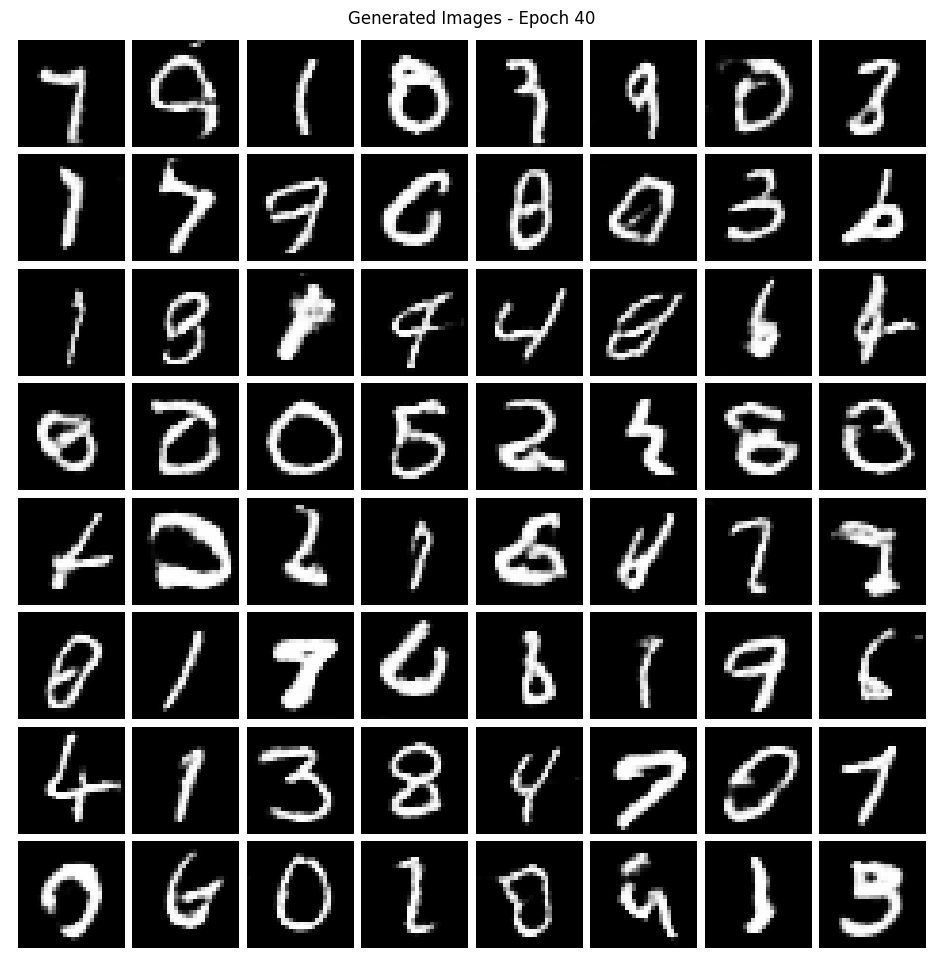

[Epoch 41/50] [Batch 0/938] [D loss: 0.6189] [G loss: 1.0075]
[Epoch 41/50] [Batch 100/938] [D loss: 0.5685] [G loss: 1.1838]
[Epoch 41/50] [Batch 200/938] [D loss: 0.5675] [G loss: 1.0180]
[Epoch 41/50] [Batch 300/938] [D loss: 0.6304] [G loss: 0.8192]
[Epoch 41/50] [Batch 400/938] [D loss: 0.5735] [G loss: 1.0517]
[Epoch 41/50] [Batch 500/938] [D loss: 0.5657] [G loss: 1.0019]
[Epoch 41/50] [Batch 600/938] [D loss: 0.6456] [G loss: 0.9374]
[Epoch 41/50] [Batch 700/938] [D loss: 0.6294] [G loss: 0.9630]
[Epoch 41/50] [Batch 800/938] [D loss: 0.6649] [G loss: 0.9363]
[Epoch 41/50] [Batch 900/938] [D loss: 0.6139] [G loss: 0.8649]
[Epoch 42/50] [Batch 0/938] [D loss: 0.5706] [G loss: 0.8069]
[Epoch 42/50] [Batch 100/938] [D loss: 0.5696] [G loss: 1.0871]
[Epoch 42/50] [Batch 200/938] [D loss: 0.6666] [G loss: 0.9422]
[Epoch 42/50] [Batch 300/938] [D loss: 0.5977] [G loss: 0.9507]
[Epoch 42/50] [Batch 400/938] [D loss: 0.6145] [G loss: 1.0302]
[Epoch 42/50] [Batch 500/938] [D loss: 0.601

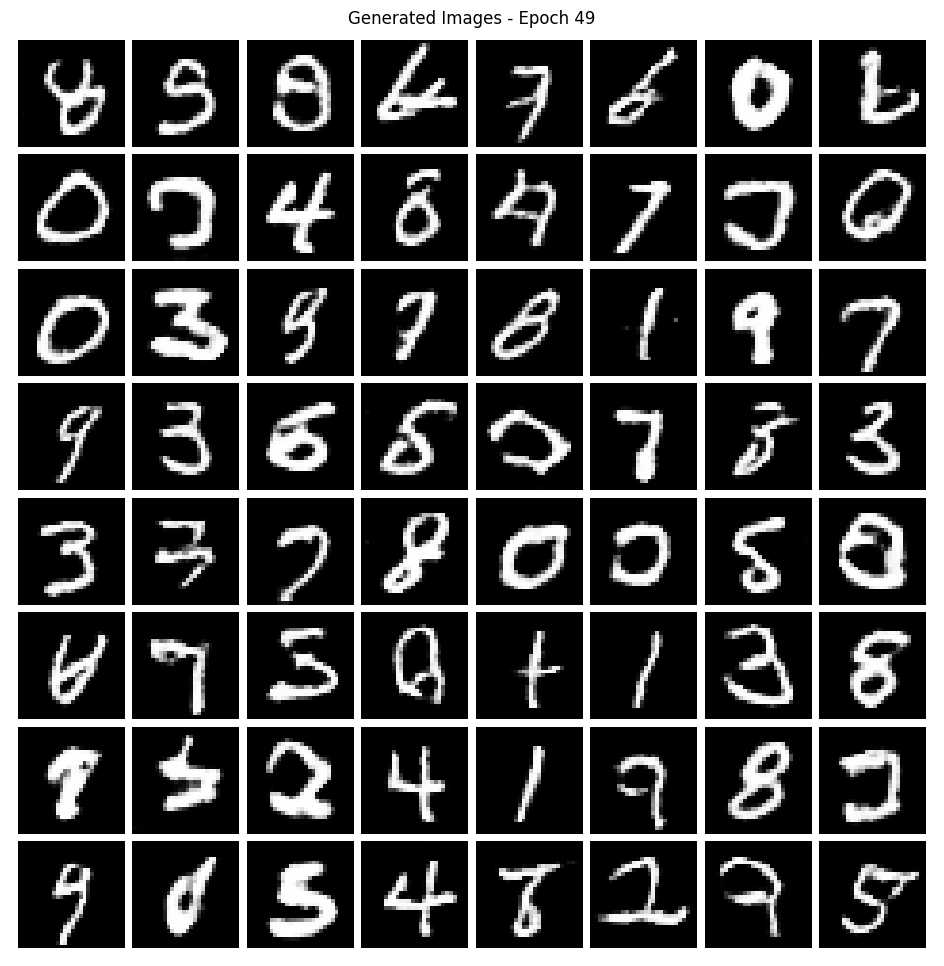

Training completed!


In [7]:
# Training loop
print("Starting training...")
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # =====================
        #  Train Discriminator
        # =====================
        optimizer_D.zero_grad()
        
        # Real images
        real_pred = discriminator(imgs)
        d_loss_real = adversarial_loss(real_pred, valid)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_pred = discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_pred, fake)
        
        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # =====================
        #  Train Generator
        # =====================
        optimizer_G.zero_grad()
        
        # Generate fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        
        # Generator wants discriminator to classify fake as real
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        # Print progress
        if i % print_every == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Save generated images at end of each epoch
    if epoch % save_every == 0 or epoch == n_epochs - 1:
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            gen_imgs = generator(z)
            show_images(gen_imgs, f"Generated Images - Epoch {epoch}")
            
            # Save to file
            save_path = f'generated_images/basic_gan/epoch_{epoch}.png'
            grid = make_grid(gen_imgs.cpu(), nrow=8, normalize=True, pad_value=1)
            plt.imsave(save_path, grid.permute(1, 2, 0).numpy())

print("Training completed!")

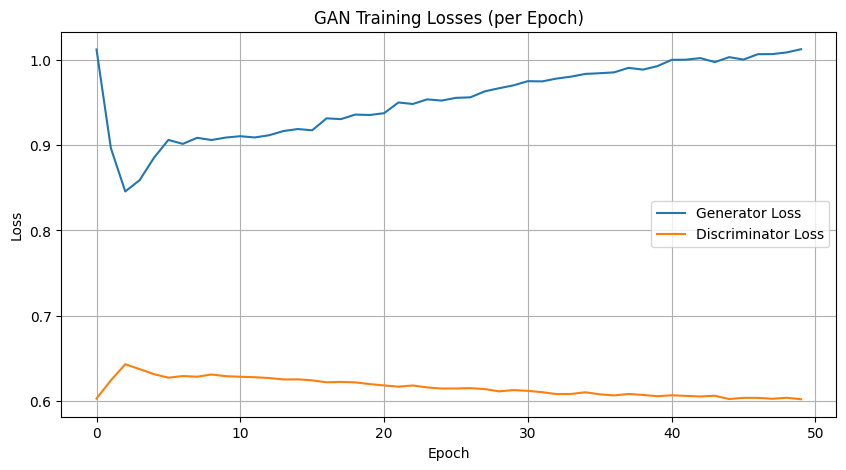

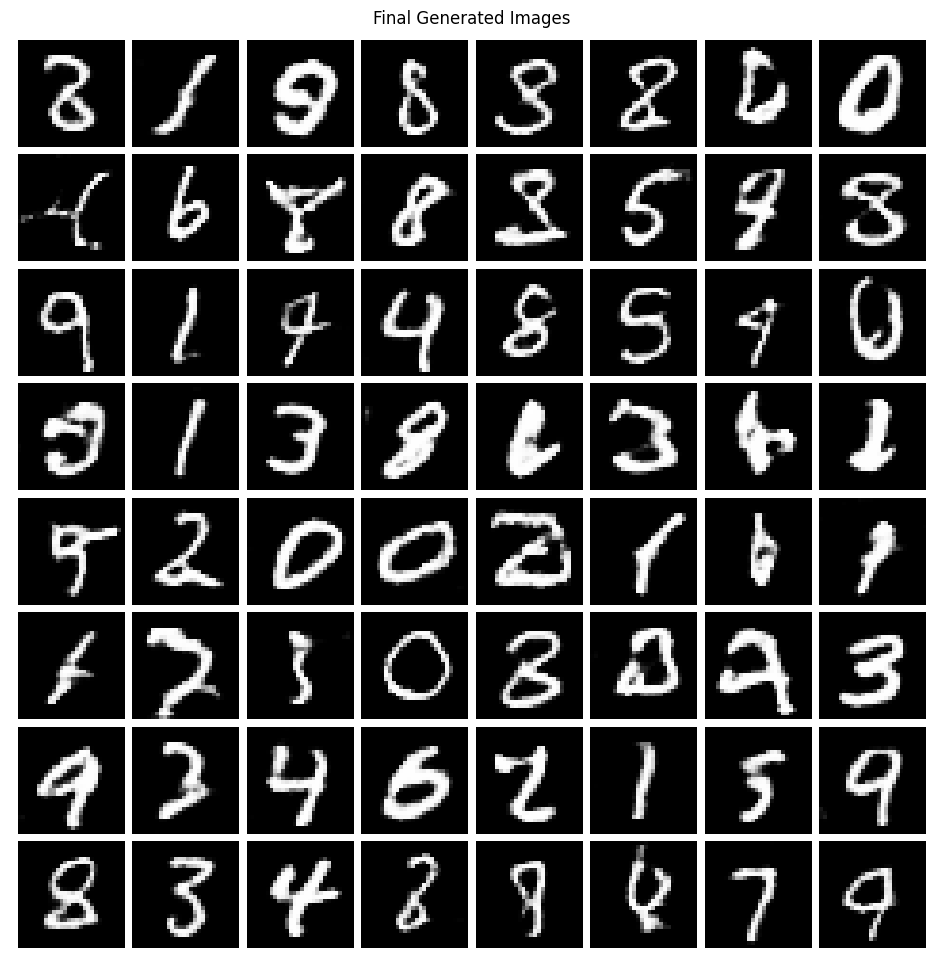

In [9]:
# Plot training losses (averaged per epoch)
batches_per_epoch = len(train_loader)
n_epochs_completed = len(G_losses) // batches_per_epoch
G_per_epoch = [np.mean(G_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
D_per_epoch = [np.mean(D_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs_completed), G_per_epoch, label='Generator Loss')
plt.plot(range(n_epochs_completed), D_per_epoch, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses (per Epoch)')
plt.legend()
plt.grid(True)
plt.show()

# Generate final sample images
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen_imgs = generator(z)
    show_images(gen_imgs, "Final Generated Images")

## Task 2: CIFAR-10 with Updated Dimensions (Assignment Requirement)

**Assignment requirement:** Replace the MNIST dataset with CIFAR-10 and update the network for the new dimensions (32×32×3).

We use a DCGAN: convolutional generator and discriminator adapted for 32×32 RGB images. Image saving every 10 epochs is used here as well.

Files already downloaded and verified


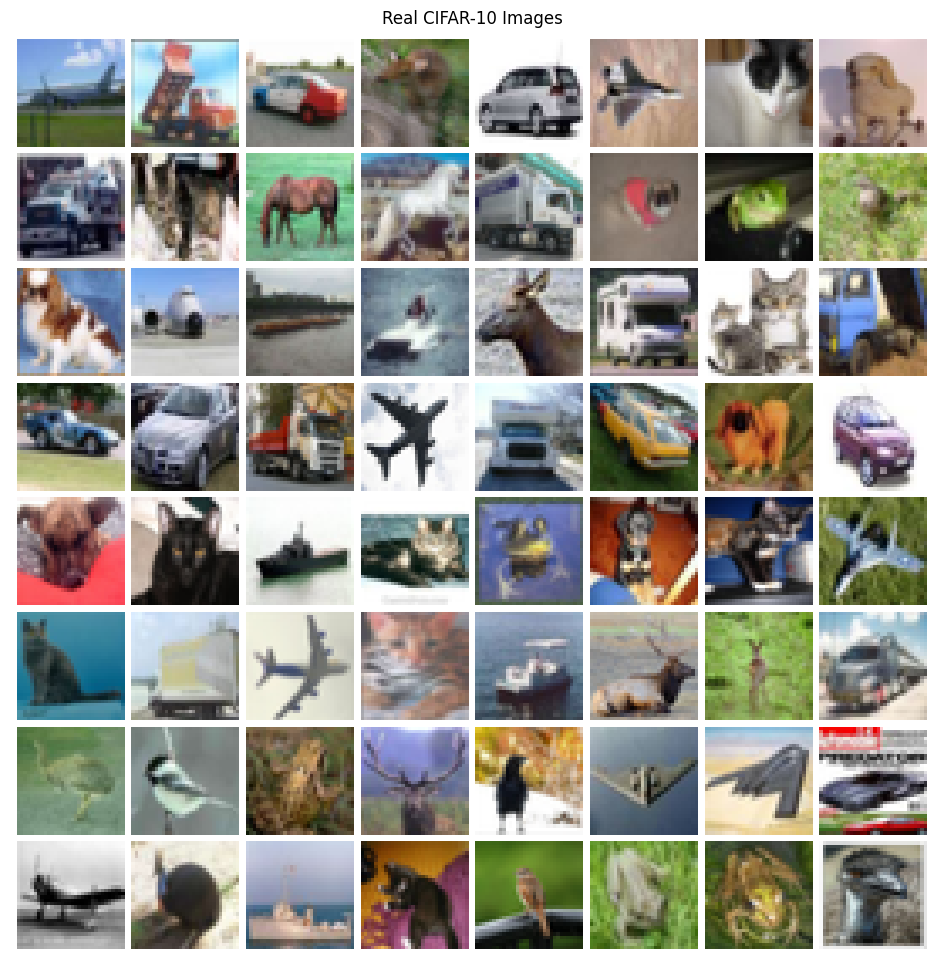

In [10]:
# Load CIFAR-10 dataset
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=64, shuffle=True, num_workers=2)

# Show sample real images
real_cifar, _ = next(iter(cifar_loader))
show_images(real_cifar[:64], "Real CIFAR-10 Images", nrow=8)

In [11]:
# DCGAN Generator
class DCGAN_Generator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=3):
        super(DCGAN_Generator, self).__init__()
        self.latent_dim = latent_dim
        
        # Project and reshape to 4x4 feature map
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        
        self.model = nn.Sequential(
            # Input: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: 64 x 32 x 32
            
            nn.ConvTranspose2d(64, n_channels, 3, 1, 1, bias=False),
            nn.Tanh()
            # Output: n_channels x 32 x 32
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.model(x)
        return x

# DCGAN Discriminator
class DCGAN_Discriminator(nn.Module):
    def __init__(self, n_channels=3):
        super(DCGAN_Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input: n_channels x 32 x 32
            nn.Conv2d(n_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 64 x 16 x 16
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 128 x 8 x 8
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 256 x 4 x 4
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 512 x 2 x 2
            
            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )
    
    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize DCGAN
dcgan_latent_dim = 100
dcgan_generator = DCGAN_Generator(latent_dim=dcgan_latent_dim).to(device)
dcgan_discriminator = DCGAN_Discriminator().to(device)

print("DCGAN Generator:")
print(dcgan_generator)
print(f"\nDCGAN Generator parameters: {count_parameters(dcgan_generator):,}")
print(f"DCGAN Discriminator parameters: {count_parameters(dcgan_discriminator):,}")

DCGAN Generator:
DCGAN_Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

DCGAN Generator parameters: 3,582,528
DCGAN Discriminator parameters: 2,759,424


Starting DCGAN training...
[Epoch 0/50] [Batch 0/782] [D loss: 0.7142] [G loss: 1.8209]
[Epoch 0/50] [Batch 100/782] [D loss: 0.2026] [G loss: 4.2696]
[Epoch 0/50] [Batch 200/782] [D loss: 0.1662] [G loss: 3.5791]
[Epoch 0/50] [Batch 300/782] [D loss: 0.2412] [G loss: 2.4351]
[Epoch 0/50] [Batch 400/782] [D loss: 0.3933] [G loss: 1.5870]
[Epoch 0/50] [Batch 500/782] [D loss: 0.4548] [G loss: 1.2762]
[Epoch 0/50] [Batch 600/782] [D loss: 0.3947] [G loss: 1.5159]
[Epoch 0/50] [Batch 700/782] [D loss: 0.3027] [G loss: 3.1634]


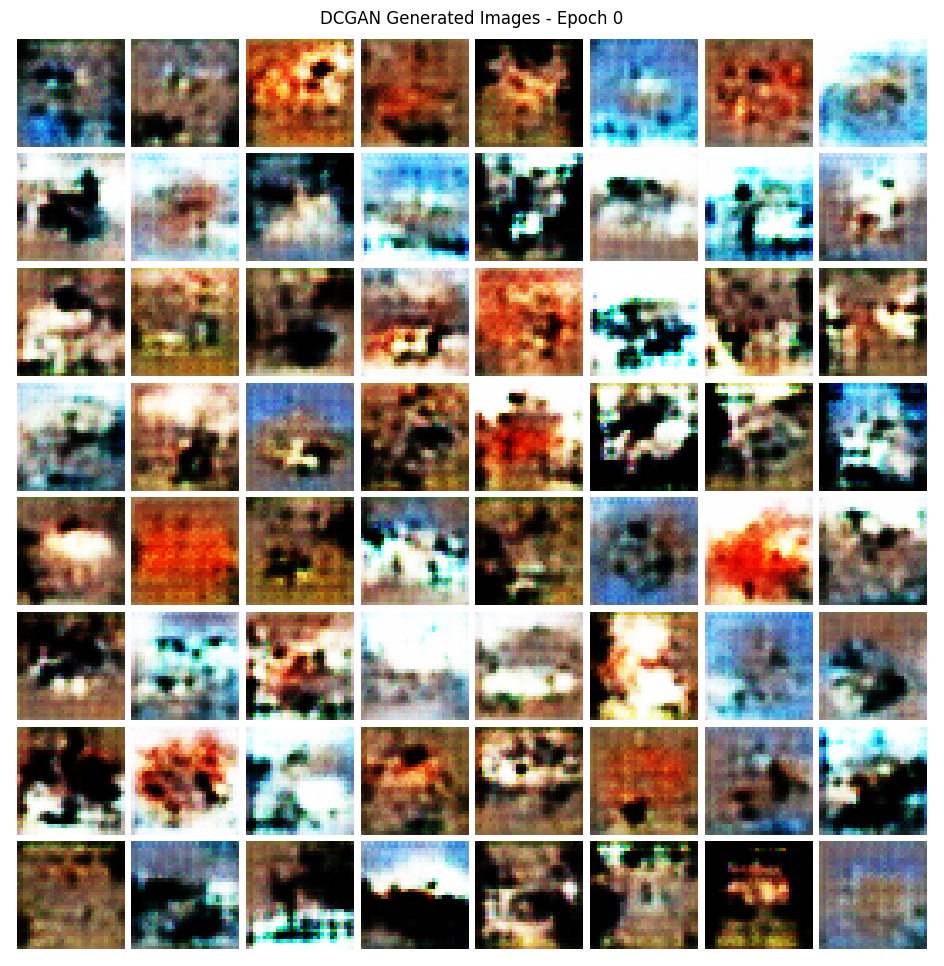

[Epoch 1/50] [Batch 0/782] [D loss: 0.6774] [G loss: 2.2863]
[Epoch 1/50] [Batch 100/782] [D loss: 0.4078] [G loss: 2.1042]
[Epoch 1/50] [Batch 200/782] [D loss: 0.2593] [G loss: 1.7309]
[Epoch 1/50] [Batch 300/782] [D loss: 0.2360] [G loss: 2.2882]
[Epoch 1/50] [Batch 400/782] [D loss: 0.1634] [G loss: 2.3345]
[Epoch 1/50] [Batch 500/782] [D loss: 0.5264] [G loss: 1.1991]
[Epoch 1/50] [Batch 600/782] [D loss: 0.4853] [G loss: 1.3355]
[Epoch 1/50] [Batch 700/782] [D loss: 0.1460] [G loss: 2.9382]
[Epoch 2/50] [Batch 0/782] [D loss: 0.3626] [G loss: 2.2238]
[Epoch 2/50] [Batch 100/782] [D loss: 1.2815] [G loss: 5.7399]
[Epoch 2/50] [Batch 200/782] [D loss: 0.2215] [G loss: 2.1837]
[Epoch 2/50] [Batch 300/782] [D loss: 0.2516] [G loss: 1.8988]
[Epoch 2/50] [Batch 400/782] [D loss: 0.3236] [G loss: 1.7939]
[Epoch 2/50] [Batch 500/782] [D loss: 0.2406] [G loss: 2.5508]
[Epoch 2/50] [Batch 600/782] [D loss: 0.4641] [G loss: 1.9831]
[Epoch 2/50] [Batch 700/782] [D loss: 0.2470] [G loss: 2.35

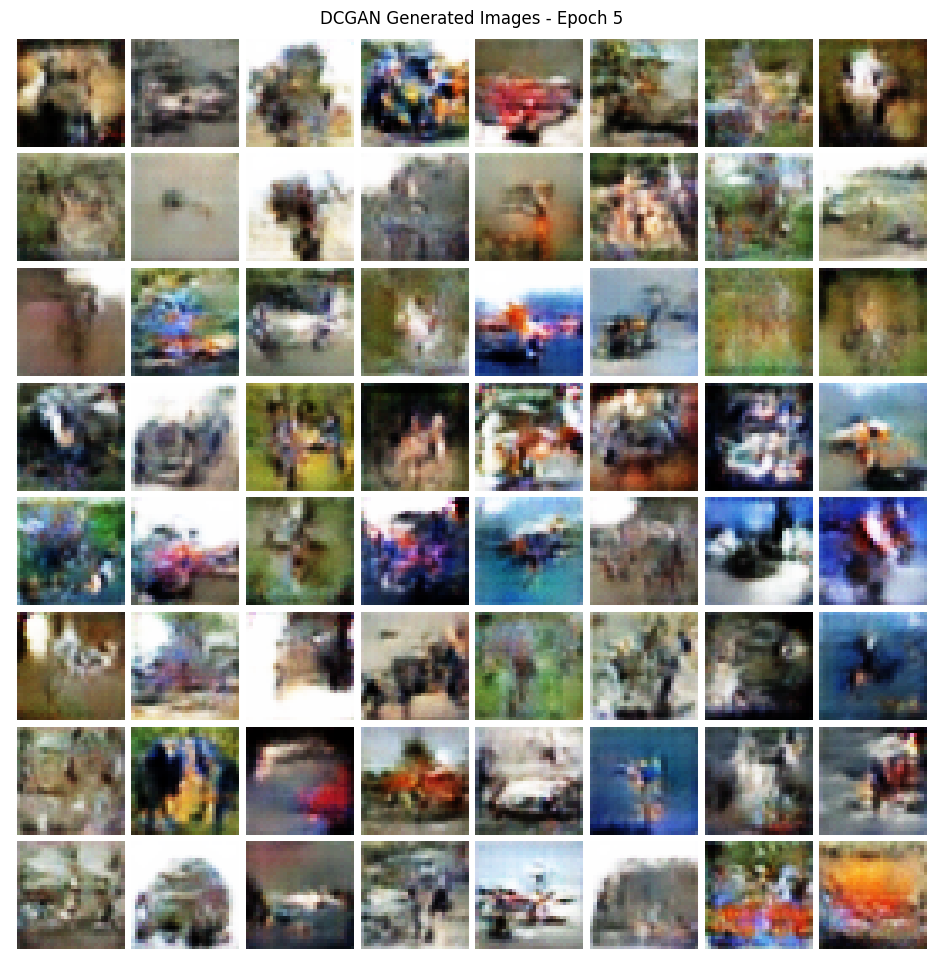

[Epoch 6/50] [Batch 0/782] [D loss: 0.0910] [G loss: 2.9175]
[Epoch 6/50] [Batch 100/782] [D loss: 0.1238] [G loss: 3.3569]
[Epoch 6/50] [Batch 200/782] [D loss: 0.3967] [G loss: 2.9169]
[Epoch 6/50] [Batch 300/782] [D loss: 0.4701] [G loss: 1.6687]
[Epoch 6/50] [Batch 400/782] [D loss: 0.1301] [G loss: 2.3111]
[Epoch 6/50] [Batch 500/782] [D loss: 0.1614] [G loss: 2.4627]
[Epoch 6/50] [Batch 600/782] [D loss: 0.9818] [G loss: 3.8527]
[Epoch 6/50] [Batch 700/782] [D loss: 0.3639] [G loss: 5.0262]
[Epoch 7/50] [Batch 0/782] [D loss: 0.5889] [G loss: 3.7663]
[Epoch 7/50] [Batch 100/782] [D loss: 0.3062] [G loss: 2.4574]
[Epoch 7/50] [Batch 200/782] [D loss: 0.0960] [G loss: 2.4075]
[Epoch 7/50] [Batch 300/782] [D loss: 0.1122] [G loss: 2.0374]
[Epoch 7/50] [Batch 400/782] [D loss: 0.1472] [G loss: 3.0021]
[Epoch 7/50] [Batch 500/782] [D loss: 0.0871] [G loss: 0.8680]
[Epoch 7/50] [Batch 600/782] [D loss: 0.0344] [G loss: 3.4858]
[Epoch 7/50] [Batch 700/782] [D loss: 0.2558] [G loss: 3.86

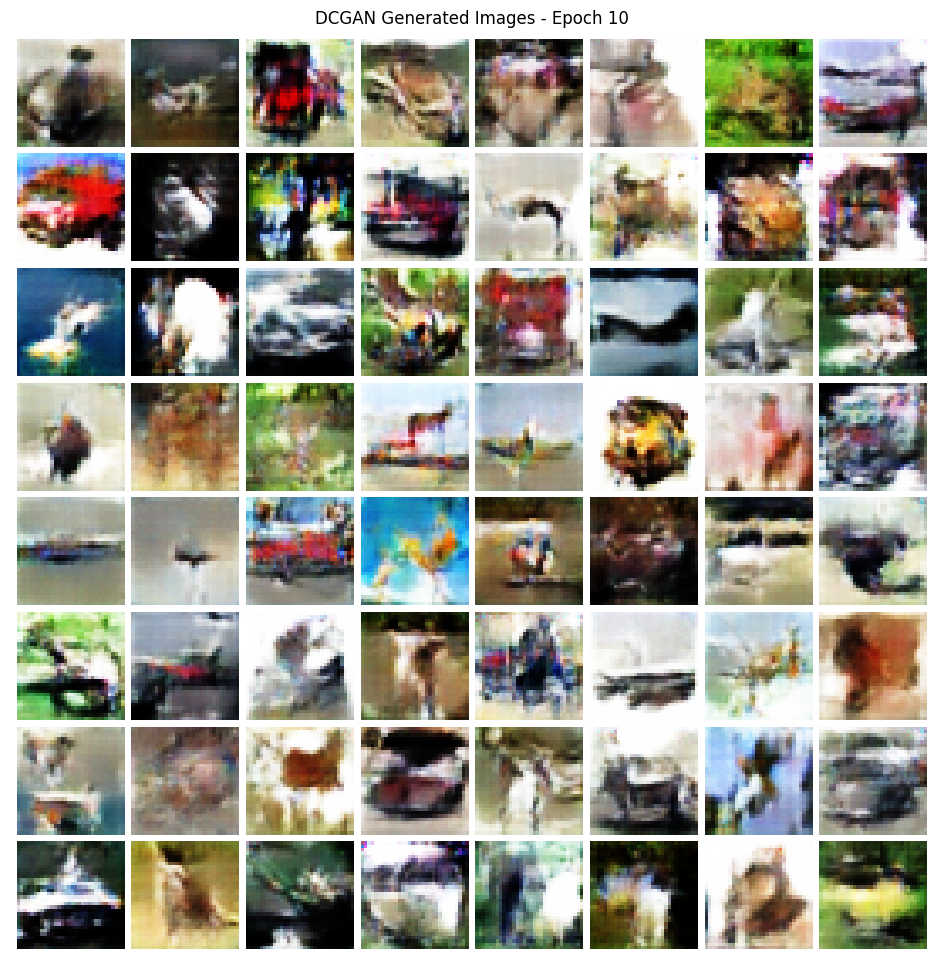

[Epoch 11/50] [Batch 0/782] [D loss: 0.0444] [G loss: 2.0395]
[Epoch 11/50] [Batch 100/782] [D loss: 0.2809] [G loss: 3.0099]
[Epoch 11/50] [Batch 200/782] [D loss: 0.1517] [G loss: 3.3750]
[Epoch 11/50] [Batch 300/782] [D loss: 0.1713] [G loss: 4.1770]
[Epoch 11/50] [Batch 400/782] [D loss: 0.2322] [G loss: 2.6654]


KeyboardInterrupt: 

In [12]:
# Optimizers for DCGAN
dcgan_optimizer_G = optim.Adam(dcgan_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
dcgan_optimizer_D = optim.Adam(dcgan_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
dcgan_epochs = 50
dcgan_G_losses = []
dcgan_D_losses = []

os.makedirs('generated_images/dcgan', exist_ok=True)

print("Starting DCGAN training...")
for epoch in range(dcgan_epochs):
    for i, (imgs, _) in enumerate(cifar_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # Train Discriminator
        dcgan_optimizer_D.zero_grad()
        
        real_pred = dcgan_discriminator(imgs)
        d_loss_real = adversarial_loss(real_pred, valid)
        
        z = torch.randn(batch_size, dcgan_latent_dim, device=device)
        fake_imgs = dcgan_generator(z)
        fake_pred = dcgan_discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        dcgan_optimizer_D.step()
        
        # Train Generator
        dcgan_optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, dcgan_latent_dim, device=device)
        gen_imgs = dcgan_generator(z)
        validity = dcgan_discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        dcgan_optimizer_G.step()
        
        dcgan_G_losses.append(g_loss.item())
        dcgan_D_losses.append(d_loss.item())
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{dcgan_epochs}] [Batch {i}/{len(cifar_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    if epoch % 5 == 0 or epoch == dcgan_epochs - 1:
        with torch.no_grad():
            z = torch.randn(64, dcgan_latent_dim, device=device)
            gen_imgs = dcgan_generator(z)
            show_images(gen_imgs, f"DCGAN Generated Images - Epoch {epoch}", nrow=8)

print("DCGAN training completed!")

## Task 3: Wasserstein GAN with Gradient Penalty (WGAN-GP)

Implement WGAN-GP to improve training stability. WGAN-GP uses the Wasserstein distance and gradient penalty instead of the standard adversarial loss.

In [ ]:
# WGAN-GP Generator (can reuse DCGAN generator)
wgan_generator = DCGAN_Generator(latent_dim=100).to(device)

# WGAN-GP Critic (similar to discriminator but without sigmoid)
class WGAN_Critic(nn.Module):
    def __init__(self, n_channels=3):
        super(WGAN_Critic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 2, 1, 0, bias=False)
            # No sigmoid - outputs raw score
        )
    
    def forward(self, img):
        return self.model(img).view(-1)

wgan_critic = WGAN_Critic().to(device)

print("WGAN-GP Critic:")
print(wgan_critic)

In [ ]:
# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN-GP"""
    batch_size = real_samples.size(0)
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    
    fake = torch.ones(batch_size, device=device, requires_grad=False)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Optimizers
wgan_optimizer_G = optim.Adam(wgan_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
wgan_optimizer_C = optim.Adam(wgan_critic.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
lambda_gp = 10
n_critic = 5  # Number of critic updates per generator update
wgan_epochs = 50
wgan_G_losses = []
wgan_C_losses = []

os.makedirs('generated_images/wgan_gp', exist_ok=True)

print("Starting WGAN-GP training...")
for epoch in range(wgan_epochs):
    for i, (imgs, _) in enumerate(cifar_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Train Critic (multiple times per generator update)
        for _ in range(n_critic):
            wgan_optimizer_C.zero_grad()
            
            # Real samples
            real_validity = wgan_critic(imgs)
            
            # Fake samples
            z = torch.randn(batch_size, 100, device=device)
            fake_imgs = wgan_generator(z)
            fake_validity = wgan_critic(fake_imgs)
            
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(wgan_critic, imgs.data, fake_imgs.data, device)
            
            # Critic loss: -E[critic(real)] + E[critic(fake)] + lambda * GP
            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            c_loss.backward()
            wgan_optimizer_C.step()
        
        # Train Generator (once per n_critic critic updates)
        wgan_optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, 100, device=device)
        gen_imgs = wgan_generator(z)
        g_validity = wgan_critic(gen_imgs)
        
        # Generator loss: -E[critic(fake)]
        g_loss = -torch.mean(g_validity)
        
        g_loss.backward()
        wgan_optimizer_G.step()
        
        wgan_G_losses.append(g_loss.item())
        wgan_C_losses.append(c_loss.item())
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{wgan_epochs}] [Batch {i}/{len(cifar_loader)}] "
                  f"[C loss: {c_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    if epoch % 5 == 0 or epoch == wgan_epochs - 1:
        with torch.no_grad():
            z = torch.randn(64, 100, device=device)
            gen_imgs = wgan_generator(z)
            show_images(gen_imgs, f"WGAN-GP Generated Images - Epoch {epoch}", nrow=8)

print("WGAN-GP training completed!")

## Task 4: Conditional GAN (cGAN)

Implement a conditional GAN that generates images conditioned on class labels. This allows controlled generation of specific classes.

In [ ]:
# Conditional Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10, n_channels=3, embed_dim=50):
        super(ConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        
        # Label embedding
        self.label_emb = nn.Embedding(n_classes, embed_dim)
        
        # Project and reshape
        self.fc = nn.Linear(latent_dim + embed_dim, 512 * 4 * 4)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, n_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        # Embed labels
        label_emb = self.label_emb(labels)
        # Concatenate noise and label embedding
        gen_input = torch.cat([z, label_emb], dim=1)
        x = self.fc(gen_input)
        x = x.view(-1, 512, 4, 4)
        x = self.model(x)
        return x

# Conditional Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes=10, n_channels=3, embed_dim=50):
        super(ConditionalDiscriminator, self).__init__()
        self.n_classes = n_classes
        
        # Label embedding
        self.label_emb = nn.Embedding(n_classes, embed_dim)
        
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Linear(512 * 2 * 2 + embed_dim, 1)
    
    def forward(self, img, labels):
        # Embed labels
        label_emb = self.label_emb(labels)
        
        # Process image
        x = self.model(img)
        x = x.view(x.size(0), -1)
        
        # Concatenate image features and label embedding
        x = torch.cat([x, label_emb], dim=1)
        validity = self.fc(x)
        return torch.sigmoid(validity)

# Initialize cGAN
cgan_generator = ConditionalGenerator().to(device)
cgan_discriminator = ConditionalDiscriminator().to(device)

print("Conditional GAN Generator:")
print(cgan_generator)
print(f"\ncGAN Generator parameters: {count_parameters(cgan_generator):,}")
print(f"cGAN Discriminator parameters: {count_parameters(cgan_discriminator):,}")

In [ ]:
# Optimizers for cGAN
cgan_optimizer_G = optim.Adam(cgan_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
cgan_optimizer_D = optim.Adam(cgan_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
cgan_epochs = 50
cgan_G_losses = []
cgan_D_losses = []

os.makedirs('generated_images/cgan', exist_ok=True)

print("Starting Conditional GAN training...")
for epoch in range(cgan_epochs):
    for i, (imgs, labels) in enumerate(cifar_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # Train Discriminator
        cgan_optimizer_D.zero_grad()
        
        # Real images with correct labels
        real_pred = cgan_discriminator(imgs, labels)
        d_loss_real = adversarial_loss(real_pred, valid)
        
        # Fake images with random labels
        z = torch.randn(batch_size, 100, device=device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_imgs = cgan_generator(z, fake_labels)
        fake_pred = cgan_discriminator(fake_imgs.detach(), fake_labels)
        d_loss_fake = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        cgan_optimizer_D.step()
        
        # Train Generator
        cgan_optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, 100, device=device)
        gen_labels = torch.randint(0, 10, (batch_size,), device=device)
        gen_imgs = cgan_generator(z, gen_labels)
        validity = cgan_discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        cgan_optimizer_G.step()
        
        cgan_G_losses.append(g_loss.item())
        cgan_D_losses.append(d_loss.item())
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{cgan_epochs}] [Batch {i}/{len(cifar_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    if epoch % 5 == 0 or epoch == cgan_epochs - 1:
        with torch.no_grad():
            # Generate images for each class
            z = torch.randn(10, 100, device=device)
            labels = torch.arange(0, 10, device=device)
            gen_imgs = cgan_generator(z, labels)
            show_images(gen_imgs, f"cGAN Generated Images (one per class) - Epoch {epoch}", nrow=10)

print("Conditional GAN training completed!")

## Task 5: Comparison and Evaluation

Compare the different GAN architectures and visualize their performance.

In [ ]:
# Compare loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(G_losses[:1000], label='Basic GAN', alpha=0.7)
plt.plot(dcgan_G_losses[:1000], label='DCGAN', alpha=0.7)
plt.plot(wgan_G_losses[:1000], label='WGAN-GP', alpha=0.7)
plt.plot(cgan_G_losses[:1000], label='cGAN', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Generator Loss')
plt.title('Generator Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(D_losses[:1000], label='Basic GAN', alpha=0.7)
plt.plot(dcgan_D_losses[:1000], label='DCGAN', alpha=0.7)
plt.plot(wgan_C_losses[:1000], label='WGAN-GP', alpha=0.7)
plt.plot(cgan_D_losses[:1000], label='cGAN', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Discriminator/Critic Loss')
plt.title('Discriminator/Critic Loss Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Show final generated images from each model
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

with torch.no_grad():
    z = torch.randn(16, 100, device=device)
    
    # DCGAN
    dcgan_imgs = dcgan_generator(z)
    axes[0, 0].imshow(make_grid(dcgan_imgs.cpu(), nrow=4, normalize=True, pad_value=1).permute(1, 2, 0))
    axes[0, 0].set_title('DCGAN')
    axes[0, 0].axis('off')
    
    # WGAN-GP
    wgan_imgs = wgan_generator(z)
    axes[0, 1].imshow(make_grid(wgan_imgs.cpu(), nrow=4, normalize=True, pad_value=1).permute(1, 2, 0))
    axes[0, 1].set_title('WGAN-GP')
    axes[0, 1].axis('off')
    
    # cGAN (specific classes)
    cgan_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], device=device)
    cgan_imgs = cgan_generator(z, cgan_labels)
    axes[1, 0].imshow(make_grid(cgan_imgs.cpu(), nrow=4, normalize=True, pad_value=1).permute(1, 2, 0))
    axes[1, 0].set_title('cGAN (Conditional)')
    axes[1, 0].axis('off')
    
    # Real images for reference
    real_batch, _ = next(iter(cifar_loader))
    axes[1, 1].imshow(make_grid(real_batch[:16], nrow=4, normalize=True, pad_value=1).permute(1, 2, 0))
    axes[1, 1].set_title('Real CIFAR-10')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Summary and Observations

### Key Observations:

1. **Basic GAN**: Simple architecture but may suffer from training instability and mode collapse.

2. **DCGAN**: Uses convolutional layers with batch normalization, providing better image quality and more stable training.

3. **WGAN-GP**: Uses Wasserstein distance with gradient penalty, offering more stable training dynamics and meaningful loss values.

4. **cGAN**: Enables controlled generation by conditioning on class labels, useful for generating specific types of images.

### Training Tips:

- Monitor both generator and discriminator losses - they should be balanced
- If discriminator loss goes to 0, the generator may stop learning
- Use appropriate learning rates (typically 0.0002 for Adam with beta1=0.5)
- Experiment with different architectures and hyperparameters
- Save checkpoints regularly to resume training if needed

### Next Steps:

- Try implementing spectral normalization
- Experiment with different loss functions (LSGAN, etc.)
- Implement evaluation metrics like FID or IS
- Try on different datasets
- Experiment with progressive growing or other advanced techniques